In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gzbuilderspirals import r_theta_from_xy, xy_from_r_theta
import spiral_utilities as su
from gzbuilderspirals import fitting

Loading NSA catalog
Loading Zooniverse classification dump
Obtaining available frame montages


In [2]:
with open('subject-id-list.csv', 'r') as f:
        subjectIds = np.array([int(n) for n in f.read().split('\n')])
        
chosenId = subjectIds[0]
gal, angle = su.get_galaxy_and_angle(chosenId)
classifications, pic_array, deprojected_image = su.get_image(
    gal, chosenId, angle
)
galaxy_object = su.get_galaxy_spirals(
    gal, angle, chosenId, classifications
)

Working on galaxy 21096909
	- USING MONTAGED IMAGE
	- Getting galaxy rotation
	- Clustering arms
	- Using saved distances
	- Fitting arms and errors


/Users/tlingard/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


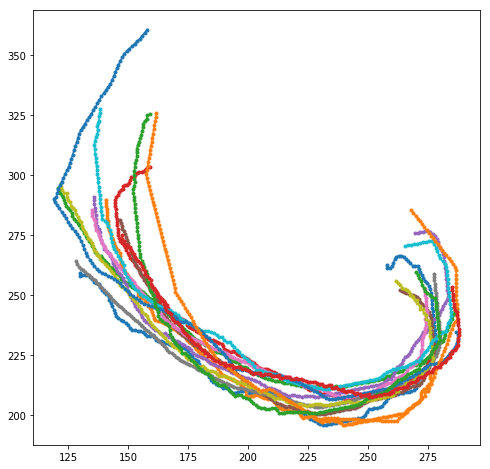

In [3]:
# which arm should we work on?
armN = 2

deprojected_arm = galaxy_object.deproject_arms()[armN]
plt.figure(0, [8]*2); [plt.plot(*arm.T, '.-') for arm in  deprojected_arm.drawn_arms]; None

(array([2., 1., 1., 1., 3., 2., 2., 0., 1., 1.]),
 array([ 23. ,  40.4,  57.8,  75.2,  92.6, 110. , 127.4, 144.8, 162.2,
        179.6, 197. ]),
 <a list of 10 Patch objects>)

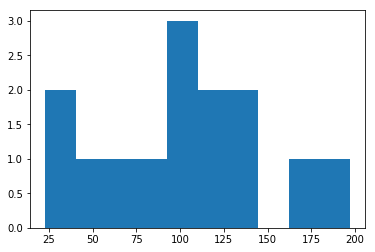

In [4]:
plt.hist([len(i) for i in galaxy_object.drawn_arms[galaxy_object.db.labels_ == armN]])

Text(0.5,0,'Radius from center')

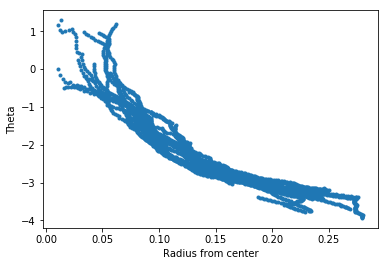

In [5]:
R, t = deprojected_arm.unwrap_and_sort()
plt.plot(R, t, '.')
plt.ylabel('Theta')
plt.xlabel('Radius from center')

In [6]:
fitting_result = fitting.fit_to_points(R, t)
fitting_result.keys()

dict_keys(['params', 'radial', 'xy_fit', 'pitch_angle', 'clf'])

In [7]:
def recursiveDictExplore(d):
    if type(d) != dict:
        return str(type(d))
    k = d.keys()
    return {i: recursiveDictExplore(d[i]) for i in k}
print(__import__('json').dumps(recursiveDictExplore(fitting_result), indent=1))

{
 "params": {
  "r_ordered": "<class 'numpy.ndarray'>",
  "theta_ordered": "<class 'numpy.ndarray'>"
 },
 "radial": {
  "log_spiral": {
   "T": "<class 'numpy.ndarray'>",
   "R": "<class 'numpy.ndarray'>",
   "error": "<class 'list'>"
  },
  "polynomial": {
   "T": "<class 'numpy.ndarray'>",
   "R": "<class 'numpy.ndarray'>",
   "error": "<class 'list'>"
  }
 },
 "xy_fit": {
  "log_spiral": "<class 'numpy.ndarray'>",
  "log_spiral_error": "<class 'list'>",
  "polynomial": "<class 'numpy.ndarray'>",
  "poly_error": "<class 'list'>"
 },
 "pitch_angle": {
  "log_spiral": "<class 'list'>",
  "poly": "<class 'list'>"
 },
 "clf": {
  "log_spiral": "<class 'sklearn.linear_model.bayes.BayesianRidge'>",
  "polynomial": "<class 'sklearn.linear_model.bayes.BayesianRidge'>",
  "polynomial-degree": "<class 'int'>"
 }
}


(-4.437168972324045, 1.794404987242545)

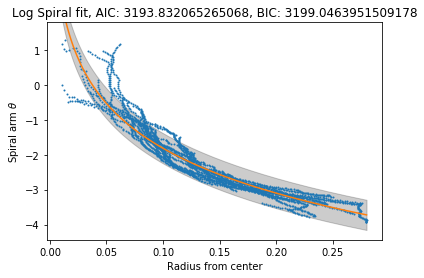

In [8]:
log_spiral = fitting.log_spiral_fit(R, t)
plt.plot(R, t, '.', markersize=2)
plt.plot(log_spiral['R'], log_spiral['T'])
plt.fill_between(
    log_spiral['R'],
    log_spiral['T'] - log_spiral['T_std'], 
    log_spiral['T'] + log_spiral['T_std'],
    color='k', alpha=0.2
)
plt.ylabel(r'Spiral arm $\theta$')
plt.xlabel('Radius from center')
plt.title('Log Spiral fit, AIC: {}, BIC: {}'.format(log_spiral['AIC'], log_spiral['BIC']))
plt.ylim(min(t)-0.5, max(t)+0.5)

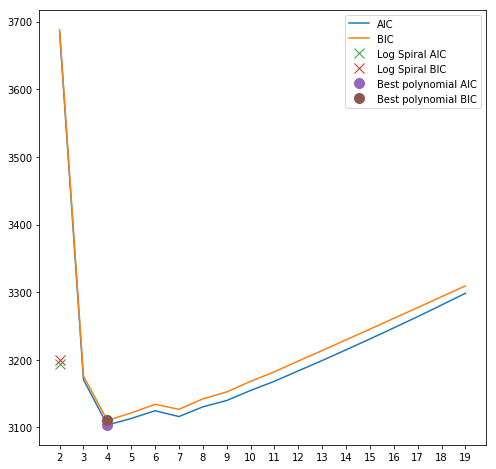

In [15]:
polynomials = fitting.get_polynomial_fits(R, t)
plt.figure(0, [8]*2)
plt.plot([i['k'] for i in polynomials], [i['AIC'] for i in polynomials], label='AIC')
plt.plot([i['k'] for i in polynomials], [i['BIC'] for i in polynomials], label='BIC')
plt.plot([2], [log_spiral['AIC']], 'x', markersize=10, label='Log Spiral AIC')
plt.plot([2], [log_spiral['BIC']], 'x', markersize=10, label='Log Spiral BIC')
best_aic = polynomials[np.argmin([i['AIC'] for i in polynomials])]
best_bic = polynomials[np.argmin([i['BIC'] for i in polynomials])]
plt.plot([best_aic['k']], [best_aic['AIC']], 'o', markersize=10, label='Best polynomial AIC')
plt.plot([best_bic['k']], [best_bic['BIC']], 'o', markersize=10, label='Best polynomial BIC')
plt.legend()
plt.xticks([i['k'] for i in polynomials])
None
# print('Log Spiral\n\tAIC: {},\n\tBIC: {}'.format(log_spiral['AIC']], log_spiral['BIC']]))
# print('Polynomial Spiral\n\tAIC: {},\n\tBIC: {}'.format(log_spiral['AIC']], log_spiral['BIC']]))

In [16]:
logSpiral_xy = xy_from_r_theta(log_spiral['R'], log_spiral['T'])

poly_best_aic_xy = xy_from_r_theta(best_aic['R'], best_aic['T'])
poly_aic_lower_xy = xy_from_r_theta(best_aic['R'], best_aic['T'] - best_aic['T_std'])
poly_aic_upper_xy = xy_from_r_theta(best_aic['R'], best_aic['T'] + best_aic['T_std'])

poly_best_bic_xy = xy_from_r_theta(best_bic['R'], best_bic['T'])
poly_bic_lower_xy = xy_from_r_theta(best_bic['R'], best_bic['T'] - best_bic['T_std'])
poly_bic_upper_xy = xy_from_r_theta(best_bic['R'], best_bic['T'] + best_bic['T_std'])

(-0.29627075929628216,
 0.07994317995866614,
 -0.1380446731704907,
 0.238963878929475)

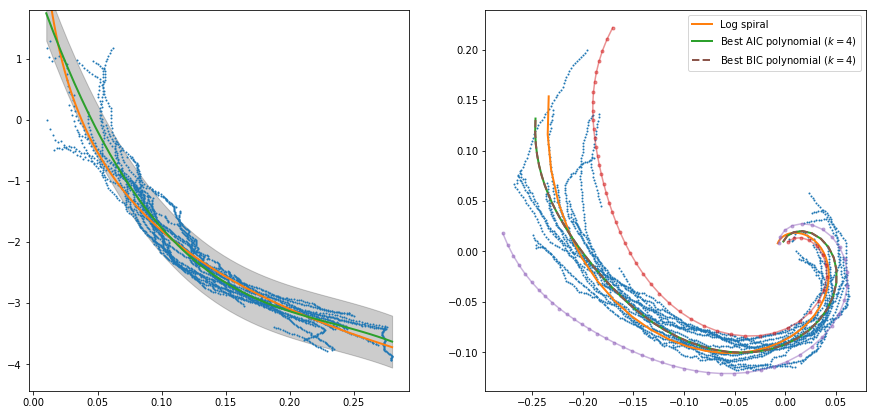

In [17]:
plt.figure(figsize=(15, 7)); plt.subplot(121)
plt.plot(R, t, '.', markersize=2)
plt.plot(log_spiral['R'], log_spiral['T'], linewidth=2)
plt.plot(best_aic['R'], best_aic['T'], linewidth=2)
plt.fill_between(
    best_aic['R'],
    best_aic['T'] - best_aic['T_std'], 
    best_aic['T'] + best_aic['T_std'],
    color='k', alpha=0.2
)
plt.ylim(min(t)-0.5, max(t)+0.5)
# plt.plot(best_bic['R'], best_bic['T'], '--', linewidth=2)
plt.subplot(122)

plt.plot(*xy_from_r_theta(R, t), '.', markersize=2)
plt.plot(*logSpiral_xy,
         linewidth=2, label='Log spiral')
plt.plot(*poly_best_aic_xy,
         linewidth=2, label='Best AIC polynomial ($k={}$)'.format(best_aic['k']))

plt.plot(*poly_aic_lower_xy, '.-', alpha=0.5)
plt.plot(*poly_aic_upper_xy, '.-', alpha=0.5)
plt.plot(*poly_best_bic_xy,
         '--', linewidth=2, label='Best BIC polynomial ($k={}$)'.format(best_bic['k']))
plt.legend()
plt.axis('equal')

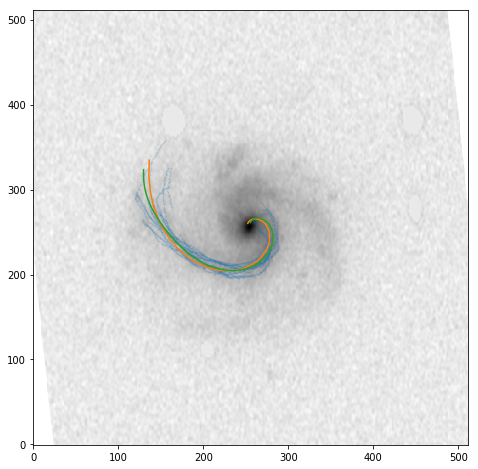

In [18]:
plt.figure(0, [8]*2)
plt.imshow(deprojected_image, cmap='gray_r', origin='lower')
plt.plot(*deprojected_arm.cleaned_cloud.T, '.', markersize=2, alpha=0.1)
plt.plot(*deprojected_arm.de_normalise(np.array(logSpiral_xy)))

plt.plot(*deprojected_arm.de_normalise(np.array(poly_best_aic_xy)))

And there we are, splines, plots and AIC

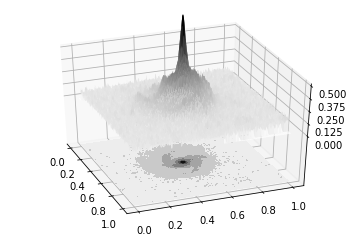

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

Z = deprojected_image

X, Y = np.meshgrid(*[np.linspace(0, 1, 512)]*2)
# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=5, cstride=5, linewidth=0.1, antialiased=True,
                cmap=cm.gray_r)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.5, cmap=cm.gray_r)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.5,0.5)
ax.set_zticks(np.linspace(0,0.5,5))
ax.view_init(35, -21)

plt.show()

In [20]:
log_spiral['clf']

BayesianRidge(alpha_1=1e-06, alpha_2=200.0, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=True, tol=0.001, verbose=False)